In [1]:
from pathlib import Path
import pandas as pd
from chap6 import download_and_unzip_spam_data, create_balanced_dataset, random_split

base_path = '/work/tmp'
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = f"{base_path}/sms_spam_collection.zip"
extracted_path = f"{base_path}/sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

df = pd.read_csv(
    data_file_path, sep="\t", header=None, names=["Label", "Text"]
)
balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv(f"{base_path}/train.csv", index=None)
validation_df.to_csv(f"{base_path}/validation.csv", index=None)
test_df.to_csv(f"{base_path}/test.csv", index=None)

/work/tmp/sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [2]:
import torch
from torch.utils.data import Dataset
import tiktoken
from chap6 import SpamDataset

tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset(f"{base_path}/train.csv", max_length=None, 
    tokenizer=tokenizer
)
val_dataset = SpamDataset(f"{base_path}/validation.csv", 
    max_length=train_dataset.max_length, tokenizer=tokenizer
)
test_dataset = SpamDataset(
    f"{base_path}/test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer
)

In [3]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [4]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [5]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available():   #1
#     device = torch.device("mps")"      
print("Device:", device)

Device: cuda


In [7]:
from gpt_download import download_and_load_gpt2
from chap4 import GPTModel
from chap5 import load_weights_into_gpt


CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,         #1
    "context_length": 1024,      #2
    "drop_rate": 0.0,            #3
    "qkv_bias": True             #4
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir=f"{base_path}/gpt2"
)


model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.to(device)

2025-03-31 00:27:03.763812: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-31 00:27:03.771596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743380823.780730    2525 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743380823.783496    2525 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743380823.790789    2525 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

File already exists and is up-to-date: /work/tmp/gpt2/124M/checkpoint
File already exists and is up-to-date: /work/tmp/gpt2/124M/encoder.json
File already exists and is up-to-date: /work/tmp/gpt2/124M/hparams.json
File already exists and is up-to-date: /work/tmp/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: /work/tmp/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: /work/tmp/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: /work/tmp/gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='tanh')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Li

In [8]:
from chap4 import generate_text_simple
from chap5 import text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer).to(device),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [9]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='tanh')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Li

In [10]:
from chap6 import calc_accuracy_loader

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)


print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [11]:
import math

class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.rank = rank
        self.alpha = alpha
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))    #1
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

    def __repr__(self):
        return f"LoRALayer(in_dim={self.in_dim}, out_dim={self.out_dim}, rank={self.rank}, alpha={self.alpha})"

In [12]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [13]:
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):     #1
            print(module)
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:    #2
            replace_linear_with_lora(module, rank, alpha)

In [14]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
    param.requires_grad = False
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 124,441,346
Total trainable parameters after: 0


In [15]:
replace_linear_with_lora(model, rank=16, alpha=16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=3072, bias=True)
Linear(in_features=3072, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=3072, bias=True)
Linear(in_features=3072, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=3072, bias=True)
Linear(in_features=3072, out_features=768, bias=True)
Linear(in_features=768, out_features=768

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer(in_dim=768, out_dim=768, rank=16, alpha=16)
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer(in_dim=768, out_dim=768, rank=16, alpha=16)
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer(in_dim=768, out_dim=768, rank=16, alpha=16)
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer(in_dim=768, out_dim=768, rank=16, alpha=16)
        )
        (dropout): Dropout(p=0

In [17]:
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [18]:
import time
from chap6 import train_classifier_simple
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=50, eval_iter=5,
        tokenizer=tokenizer
    )

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.820, Val loss 3.462
Ep 1 (Step 000050): Train loss 0.396, Val loss 0.364
Ep 1 (Step 000100): Train loss 0.111, Val loss 0.229
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150): Train loss 0.135, Val loss 0.073
Ep 2 (Step 000200): Train loss 0.010, Val loss 0.046
Ep 2 (Step 000250): Train loss 0.024, Val loss 0.159
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.019, Val loss 0.122
Ep 3 (Step 000350): Train loss 0.036, Val loss 0.264
Training accuracy: 100.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.119, Val loss 0.038
Ep 4 (Step 000450): Train loss 0.032, Val loss 0.167
Ep 4 (Step 000500): Train loss 0.003, Val loss 0.418
Training accuracy: 100.00% | Validation accuracy: 92.50%
Ep 5 (Step 000550): Train loss 0.002, Val loss 0.384
Ep 5 (Step 000600): Train loss 0.001, Val loss 0.008
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 10.25 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


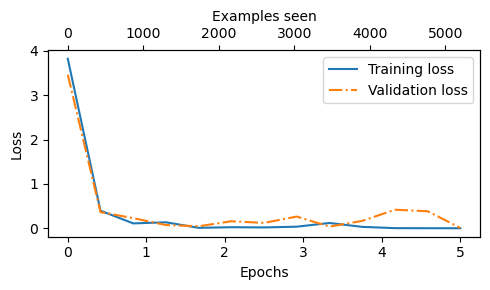

In [22]:
%load_ext autoreload
%autoreload 2
from chap6 import plot_values

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(
    epochs_tensor, examples_seen_tensor, 
    train_losses, val_losses, label="loss"
)

In [23]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.81%
Validation accuracy: 97.32%
Test accuracy: 97.00%
